# Belief Vector Fields

## DialoGPT

##### Import

In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: DialoGPT-medium (GPT-2 family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install transformers datasets accelerate torch --upgrade

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "microsoft/DialoGPT-medium"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337

MAX_SEQ_LEN             = 128           # keep moderate to control memory
BATCH_SIZE              = 1             # larger works, but this is safest for V~50k
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; raise for smoother curves
TOKENS_PER_EX           = 32            # per example: keep last K supervised steps
TAU                     = 1.0           # temperature in the softmax for q_ell
FR_NORM                 = True          # if True, report 2*||v|| (FR norm); else ||v|| Euclidean
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

transformer = model.transformer       # GPT2Model
blocks      = transformer.h           # list of decoder blocks
final_ln    = transformer.ln_f        # final LayerNorm (used by top head)
lm_head     = model.lm_head           # tied unembedding
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size

print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 24  |  Vocab: 50257


##### Dataset: AG News

In [ ]:
# Concepts from AG News
# Labels: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
# We'll take three contrasting concepts: World, Sports, Sci/Tech
# ----------------------------
def build_text_agnews(example):

    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B,S)
    attn_mask = tok["attention_mask"]       # (B,S)

    # shift for next-token prediction
    x   = input_ids[:, :-1].contiguous()
    y   = input_ids[:,  1:].contiguous()
    msk = attn_mask[:, 1:].contiguous()

    # ignore padding
    y = y.masked_fill(msk == 0, -100)

    # Now per-sample, keep only last K supervised positions (where y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    # We'll carry the full x to produce corresponding hidden states,
    # but only use positions where sel_mask==True to build belief vectors.
    return {
        "input_ids": x,
        "labels": y,
        "select_mask": sel_mask,   # (B,S-1) booleans, True for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

##### Function for Core Computation

In [ ]:
# Core computation

@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    # Accumulators: per-layer sums over selected positions
    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x      = batch["input_ids"].to(DEVICE)     # (B,S)
        y      = batch["labels"].to(DEVICE)        # (B,S)
        keep_m = batch["select_mask"].to(DEVICE)   # (B,S)

        B, S = x.shape

        # Build embeddings like GPT-2 forward: wte + wpe + drop
        with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                            dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
            pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
            h = transformer.wte(x) + transformer.wpe(pos_ids)
            h = transformer.drop(h)

        # Sequentially traverse layers
        for ell in range(num_layers):
            with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                                dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
                h = blocks[ell](h)[0]                 # (B,S,d)
                z = lm_head(final_ln(h))              # (B,S,V) logits at layer ell

            # flatten to (B*S, V), but keep only selected positions
            keep = keep_m.view(-1)                   # (B*S,)
            if keep.any():
                z_sel = z.view(-1, z.size(-1))[keep]          # (N_sel, V) half precision
                y_sel = y.view(-1)[keep]                       # (N_sel,)

                # Compute q,u in float32 for stability
                z32 = z_sel.float() / TAU
                q   = F.softmax(z32, dim=-1)                   # (N_sel, V)
                q = torch.clamp(q, min=1e-12)                  # stabilize
                u   = torch.sqrt(q)                            # (N_sel, V)

                # Build g = (1/tau)(e_y - q) without one-hot
                g = -q / TAU                                   # (N_sel, V)
                # add +1/tau at the target indices
                add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
                g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

                # Compute t = (1/(2*tau)) * [ u*g - ( (q*g).sum(-1) * u ) ]
                ug = u * g                                     # (N_sel, V)
                s  = (q * g).sum(dim=-1, keepdim=True)         # (N_sel, 1)
                t  = (ug - s * u) / (2.0 * TAU)                # (N_sel, V)

                # Accumulate sums over selected positions
                v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
                u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
                cnt[ell]   += t.size(0)

    # Finalize per-layer vectors: average, rebase to mean u, measure norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)
        # normalize u_avg to unit sphere (anchor base point)
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm
        # project v_avg into tangent at u_bar: remove radial component
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar
        # report FR norm (2*||·||) or Euclidean norm
        n = 2.0 * torch.linalg.norm(v_tan).item() if FR_NORM else torch.linalg.norm(v_tan).item()
        norms.append(n)
    return np.array(norms, dtype=float)


##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:03<00:00, 40.86it/s]


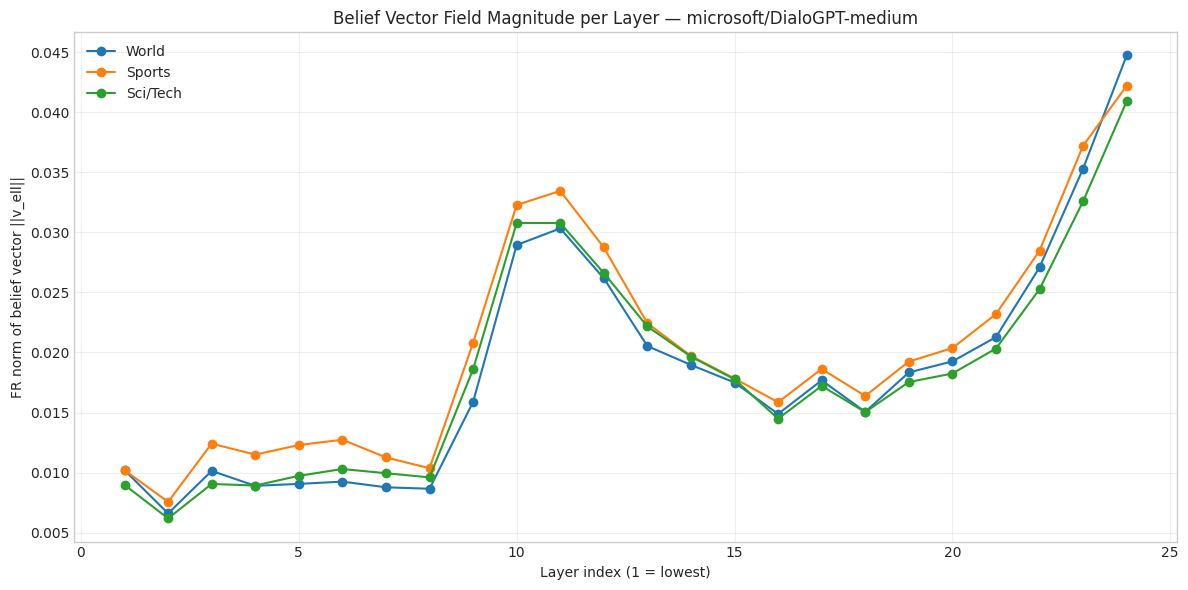

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ||v_ell||" if FR_NORM else "Euclidean norm of belief vector ||v_ell||"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## GPT-2

##### Import

In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: DialoGPT-medium (GPT-2 family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install transformers datasets accelerate torch --upgrade

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "gpt2"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337
MAX_SEQ_LEN             = 128           # keep moderate to control memory
BATCH_SIZE              = 1             # larger works, but this is safest for V~50k
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; raise for smoother curves
TOKENS_PER_EX          = 32            # per example: keep last K supervised steps
TAU                     = 1.0           # temperature in the softmax for q_ell
FR_NORM                 = True          # if True, report 2*||v|| (FR norm); else ||v|| Euclidean
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

transformer = model.transformer       # GPT2Model
blocks      = transformer.h           # list of decoder blocks
final_ln    = transformer.ln_f        # final LayerNorm (used by top head)
lm_head     = model.lm_head           # tied unembedding
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size

print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 12  |  Vocab: 50257


##### Dataset: AG News

In [ ]:
# Concepts from AG News
# Labels: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
# We'll take three contrasting concepts: World, Sports, Sci/Tech
# ----------------------------
def build_text_agnews(example):

    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B,S)
    attn_mask = tok["attention_mask"]       # (B,S)

    # shift for next-token prediction
    x   = input_ids[:, :-1].contiguous()
    y   = input_ids[:,  1:].contiguous()
    msk = attn_mask[:, 1:].contiguous()

    # ignore padding
    y = y.masked_fill(msk == 0, -100)

    # Now per-sample, keep only last K supervised positions (where y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    # We'll carry the full x to produce corresponding hidden states,
    # but only use positions where sel_mask==True to build belief vectors.
    return {
        "input_ids": x,
        "labels": y,
        "select_mask": sel_mask,   # (B,S-1) booleans, True for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

##### Function for Core Computation

In [ ]:
# Core computation

@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    # Accumulators: per-layer sums over selected positions
    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x      = batch["input_ids"].to(DEVICE)     # (B,S)
        y      = batch["labels"].to(DEVICE)        # (B,S)
        keep_m = batch["select_mask"].to(DEVICE)   # (B,S)

        B, S = x.shape

        # Build embeddings like GPT-2 forward: wte + wpe + drop
        with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                            dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
            pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
            h = transformer.wte(x) + transformer.wpe(pos_ids)
            h = transformer.drop(h)

        # Sequentially traverse layers
        for ell in range(num_layers):
            with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                                dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
                h = blocks[ell](h)[0]                 # (B,S,d)
                z = lm_head(final_ln(h))              # (B,S,V) logits at layer ell

            # flatten to (B*S, V), but keep only selected positions
            keep = keep_m.view(-1)                   # (B*S,)
            if keep.any():
                z_sel = z.view(-1, z.size(-1))[keep]          # (N_sel, V) half precision
                y_sel = y.view(-1)[keep]                       # (N_sel,)

                # Compute q,u in float32 for stability
                z32 = z_sel.float() / TAU
                q   = F.softmax(z32, dim=-1)                   # (N_sel, V)
                q = torch.clamp(q, min=1e-12)                  # stabilize
                u   = torch.sqrt(q)                            # (N_sel, V)

                # Build g = (1/tau)(e_y - q) without one-hot
                g = -q / TAU                                   # (N_sel, V)
                # add +1/tau at the target indices
                add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
                g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

                # Compute t = (1/(2*tau)) * [ u*g - ( (q*g).sum(-1) * u ) ]
                ug = u * g                                     # (N_sel, V)
                s  = (q * g).sum(dim=-1, keepdim=True)         # (N_sel, 1)
                t  = (ug - s * u) / (2.0 * TAU)                # (N_sel, V)

                # Accumulate sums over selected positions
                v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
                u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
                cnt[ell]   += t.size(0)

            # else: no selected positions; just continue

    # Finalize per-layer vectors: average, rebase to mean u, measure norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)
        # normalize u_avg to unit sphere (anchor base point)
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm
        # project v_avg into tangent at u_bar: remove radial component
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar
        # report FR norm (2*||·||) or Euclidean norm
        n = 2.0 * torch.linalg.norm(v_tan).item() if FR_NORM else torch.linalg.norm(v_tan).item()
        norms.append(n)
    return np.array(norms, dtype=float)

##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:01<00:00, 79.97it/s]


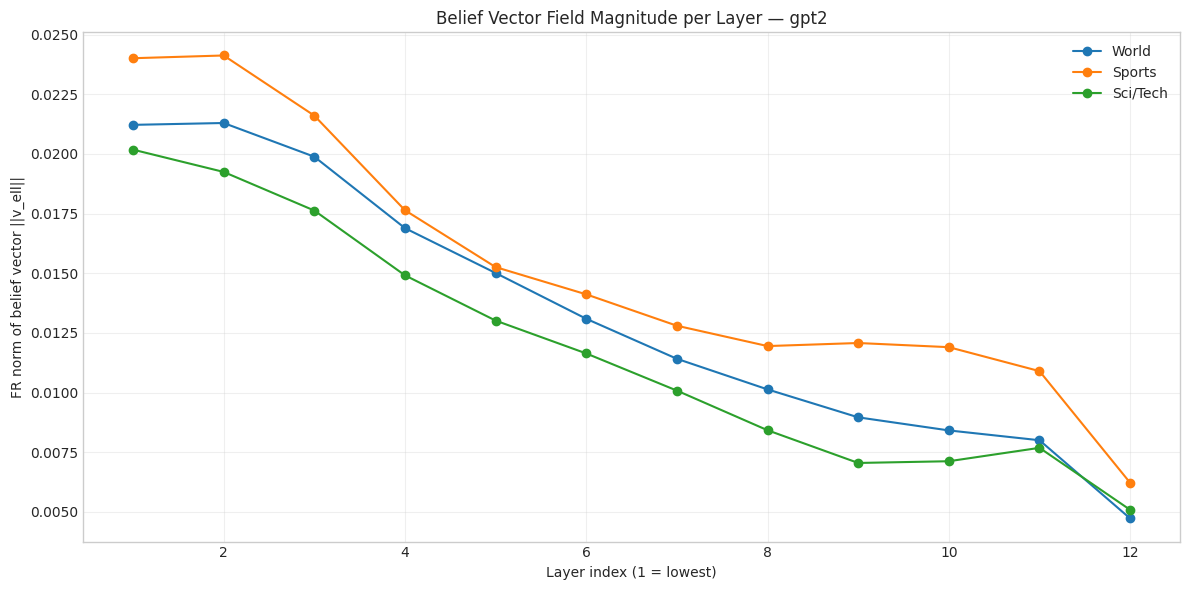

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ||v_ell||" if FR_NORM else "Euclidean norm of belief vector ||v_ell||"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## TInyLlama - 1.1B


##### Import


In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0 (LLaMA family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install --upgrade transformers datasets accelerate torch

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337

MAX_SEQ_LEN             = 128           # modest length to control memory
BATCH_SIZE              = 1             # safe for large vocab
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; increase for smoother curves
TOKENS_PER_EX           = 32            # keep last K supervised positions
TAU                     = 1.0           # softmax temperature for q
FR_NORM                 = True          # if True, report Fisher-Rao norm (2*||v||); else Euclidean ||v||
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro & perf knobs
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)
# speed/memory: no KV cache needed since we do full-seq forward once
if hasattr(model.config, "use_cache"):
    model.config.use_cache = False

# LLaMA components
llama_model = model.model               # LlamaModel
blocks      = llama_model.layers        # list of LlamaDecoderLayer
final_norm  = llama_model.norm          # final RMSNorm before lm_head
lm_head     = model.lm_head
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size
print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 22  |  Vocab: 32000


##### Dataset: AG News

In [ ]:
def build_text_agnews(example):
    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


##### Function for Core Computation

In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B, S)
    attn_mask = tok["attention_mask"]       # (B, S)

    # teacher-forced shift
    x        = input_ids[:, :-1].contiguous()          # (B, S-1)
    y        = input_ids[:,  1:].contiguous()          # (B, S-1)
    attn_x   = attn_mask[:, :-1].contiguous()          # (B, S-1)
    attn_y   = attn_mask[:,  1:].contiguous()          # (B, S-1)

    # ignore padding in labels
    y = y.masked_fill(attn_y == 0, -100)

    # per-sample: keep only last K supervised positions (y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    return {
        "input_ids": x,          # (B, S-1)
        "attention_mask": attn_x,# (B, S-1) important for LLaMA to mask pads
        "labels": y,             # (B, S-1)
        "select_mask": sel_mask, # (B, S-1) booleans for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

In [ ]:
@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    autocast_kwargs = dict(
        device_type=("cuda" if DEVICE=="cuda" else "cpu"),
        dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")
    )

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x       = batch["input_ids"].to(DEVICE)       # (B, S)
        attn    = batch["attention_mask"].to(DEVICE)  # (B, S)
        y       = batch["labels"].to(DEVICE)          # (B, S)
        keep_m  = batch["select_mask"].to(DEVICE)     # (B, S)
        B, S    = x.shape

        # Single forward to get ALL layer hidden states (LLaMA-friendly)
        with torch.autocast(**autocast_kwargs):
            outputs = model(
                input_ids=x,
                attention_mask=attn,
                use_cache=False,
                output_hidden_states=True,
            )
            # outputs.hidden_states: tuple of length (num_layers + 1), including embeddings at index 0
            hidden_states = outputs.hidden_states  # tuple[ (B,S,d) ... ]

        # For each layer ell, get its post-layer hidden state = hidden_states[ell+1]
        for ell in range(num_layers):
            with torch.autocast(**autocast_kwargs):
                h_ell = hidden_states[ell + 1]          # (B, S, d)
                z     = lm_head(final_norm(h_ell))      # logit lens at layer ell: (B, S, V)

            # keep only selected positions for supervised steps
            keep = keep_m.view(-1)                      # (B*S,)
            if not keep.any():
                continue

            z_sel = z.view(-1, z.size(-1))[keep]       # (N_sel, V)
            y_sel = y.view(-1)[keep]                   # (N_sel,)

            # q,u in float32 for numerical stability
            z32 = (z_sel.float() / TAU)
            q   = F.softmax(z32, dim=-1)               # (N_sel, V)
            q   = torch.clamp(q, min=1e-12)
            u   = torch.sqrt(q)                        # (N_sel, V)

            # g = (1/τ)(e_y - q) without building one-hot explicitly
            g = -q / TAU                               # start with -q/τ
            add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
            g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

            # t = (1/(2τ)) * [Diag(u)g - u (q^T g)] ; implement as (ug - s*u)/(2τ)
            ug = u * g                                  # (N_sel, V)
            s  = (q * g).sum(dim=-1, keepdim=True)      # (N_sel, 1)
            t  = (ug - s * u) / (2.0 * TAU)             # (N_sel, V)  -- already tangent

            # Accumulate across selected positions
            v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
            u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
            cnt[ell]   += t.size(0)

    # Finalize per-layer vectors: average, anchor at mean u, project, take norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)

        # anchor: normalize u_avg to the sphere
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm

        # project v_avg into tangent at u_bar (remove any residual radial part)
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar

        n = torch.linalg.norm(v_tan).item()
        norms.append(2.0 * n if FR_NORM else n)

    return np.array(norms, dtype=float)

##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:03<00:00, 39.69it/s]


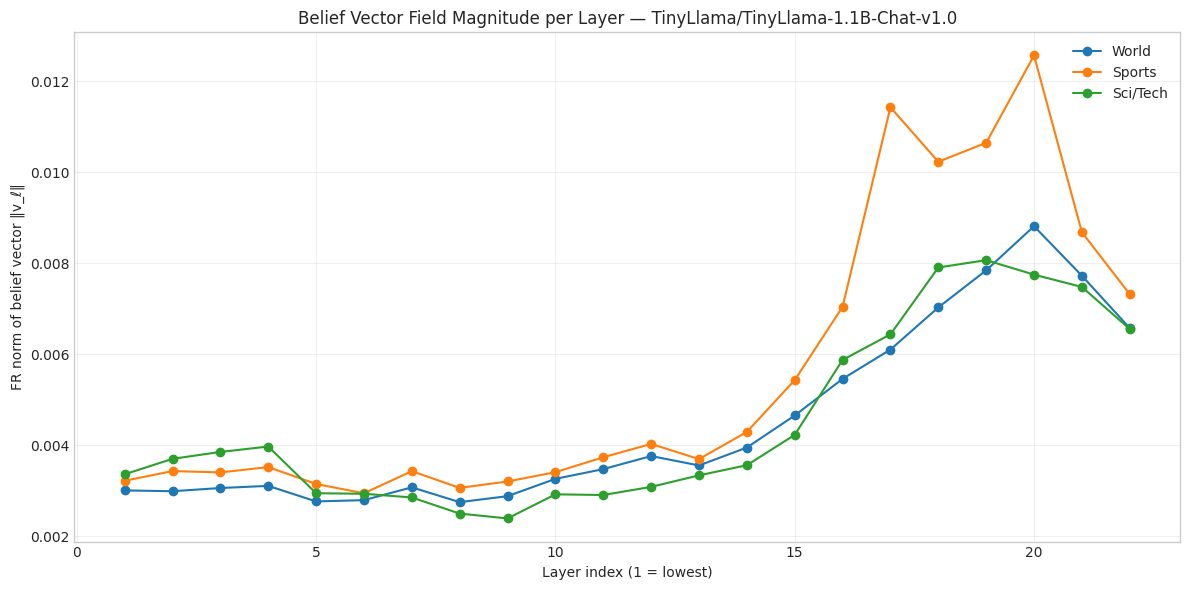

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ‖v_ℓ‖" if FR_NORM else "Euclidean norm of belief vector ‖v_ℓ‖"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
